#### Data Cleaning

In [1]:
import pandas as pd
import duckdb
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
db_path = '../../database/nsw_doe_data_case_study.duckdb'
con = duckdb.connect(db_path)
con.execute("CREATE TABLE student_attendance_data AS SELECT * FROM read_csv_auto('../../data/attendance_data.csv');")
con.commit()
# Close the connection.
con.close()

In [3]:
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=True)
results = con.execute("SELECT * FROM multi_age_composite_dataset LIMIT 10").fetchall()
print(results)


[(1001, 'Abbotsford Public School', 11, 302, '50', '53.5', 6, 176, '25', '29.5', 6, 172, '25', '28.4', 8, 225, '32', '35.4', 12, 349, '50', '56.5', 7, 182, '30.4', '31.9', 11, 304, '52.4', '58.7', 11, 299, '57.9', '61.9'), (1002, 'Aberdeen Public School', 1, 29, '12.5', '14.5', 4, 106, '44.4', '49.5', 5, 132, '55.6', '55.9', 5, 132, '55.6', '57.9', 5, 109, '50', '53.2', 7, 184, '87.5', '89.3', 6, 145, '75', '78.4', 2, 54, '25', '33.3'), (1003, 'Abermain Public School', 8, 189, '88.9', '90.9', 5, 142, '55.6', '63.7', 6, 167, '60', '65.2', 5, 140, '45.5', '52.8', 6, 173, '46.2', '58.6', 6, 160, '50', '57.6', 11, 270, '100', '100', 6, 154, '50', '57.9'), (1007, 'Adaminaby Public School', 1, 19, '100', '100', 1, 22, '100', '100', 1, 23, '100', '100', 1, 16, '100', '100', 1, 17, '100', '100', 1, 19, '100', '100', 1, 16, '100', '100', 1, 13, '100', '100'), (1008, 'Adamstown Public School', 5, 148, '55.6', '64.1', 4, 111, '44.4', '47.6', 7, 181, '63.6', '69.3', 6, 163, '54.5', '60.8', 7, 190,

In [ ]:
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=True)
table_list = con.execute("SHOW TABLES").fetchall()
print(table_list)


In [ ]:
# Define constants
years = ['14', '15', '16', '17', '18', '19', '21', '22']
measures = ['COMPOSITE_CLASS_COUNT', 'COMPOSITE_CLASS_STUDENTS', 'PCT_COMPOSITE_CLASSES', 'PCT_COMPOSITE_CLASS_STUDENTS']
# Flatten the table
flattened_queries = []
for year in years:
    year_cols = [f"{measure}_{year} AS {measure}" for measure in measures]
    query = f"""
    SELECT 
        School_code,
        School_Name,
        '20{year}' AS Year,
        {', '.join(year_cols)}
    FROM multi_age_composite_dataset
    """
    flattened_queries.append(query)
final_flattened_query = "\nUNION ALL\n".join(flattened_queries)
con.execute(f"CREATE TABLE multi_age_composite_unpivoted AS {final_flattened_query}")

In [ ]:
import duckdb
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb')
columns = con.execute("PRAGMA table_info(student_attendance_dataset)").fetchall()
year_columns = [str(row[1]) for row in columns if row[1].isdigit()]
sql_parts = []
for year in year_columns:
    sql_part = f"""
    SELECT 
        school_code AS School_Code,
        school_name AS School_Name,
        '{year}' AS Year,
        "{year}" AS Attendance_pct
    FROM student_attendance_dataset
    """
    sql_parts.append(sql_part)
sql_command = "\nUNION ALL\n".join(sql_parts)
con.execute(f"CREATE TABLE student_attendance_unpivoted AS {sql_command}")
con.close()

In [ ]:
# Establish a connection
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb', read_only=False)
query = """
ALTER TABLE unpivoted_dataset RENAME TO multi_age_composite_unpivoted;
"""
con.execute(query)
# Close the connection
con.close()

In [ ]:
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=False)
df = con.sql('select * from multi_age_composite_unpivoted').df()
print(df.shape)
df.head()


In [ ]:
con.close()

In [ ]:
query = "SELECT * FROM public_school_nsw_master_dataset"
df = con.execute(query).fetchdf()  # Use fetchdf() to get a DataFrame
# Save the DataFrame to Excel
excel_path = "public_school_nsw_master_dataset.xlsx"
df.to_excel(excel_path, index=False, engine='openpyxl')

#### Missing Value Statistics

In [4]:
# Step 1: Connect to the database
con.close()
database_path = '../../database/nsw_doe_data_case_study.duckdb'
database_connection = duckdb.connect(database_path, read_only=False)
# Step 2: Define a function that calculates and shows missing data
def get_missing_data_info(data_frame):
    # Count how many missing values there are
    missing_count = data_frame.isnull().sum()
        # Find out the percentage of missing values
    missing_percentage = (missing_count / len(data_frame)) * 100
        # Put our results in a table and return it
    result_table = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percentage
    })
    # Sorting the results to make it more readable
    result_table = result_table.sort_values(by='Missing %', ascending=False)
    return result_table
# Step 3: Get data from the database
data_from_public_schools = database_connection.execute("SELECT * FROM public_school_nsw_master_dataset").fetchdf()
data_from_multi_age = database_connection.execute("SELECT * FROM multi_age_composite_unpivoted").fetchdf()
data_from_attendance = database_connection.execute("SELECT * FROM student_attendance_unpivoted").fetchdf()
# Step 4: Use our function on the data and print the results
print("Info on Missing Data in public_school_nsw_master_dataset")
print(get_missing_data_info(data_from_public_schools))
print("------\n")

print("Info on Missing Data in multi_age_composite_unpivoted")
print(get_missing_data_info(data_from_multi_age))
print("------\n")

print("Info on Missing Data in student_attendance_unpivoted")
print(get_missing_data_info(data_from_attendance))
print("------\n")


Info on Missing Data in public_school_nsw_master_dataset
                                        Missing Count   Missing %
SUPPORT_CLASSES                                  2216  100.000000
INDIGENOUS_PCT                                    531   23.962094
LBOTE_PCT                                         376   16.967509
FAX                                                99    4.467509
ICSEA_VALUE                                        59    2.662455
LATEST_YEAR_ENROLMENT_FTE                          50    2.256318
ASSETS UNIT                                        38    1.714801
AECG_REGION                                        24    1.083032
TOWN_SUBURB                                        20    0.902527
FACS_DISTRICT                                      10    0.451264
LOCAL_HEALTH_DISTRICT                              10    0.451264
FED_ELECTORATE                                      8    0.361011
ELECTORATE_2015_2022                                8    0.361011
PHONE              

##### Missing value imputation

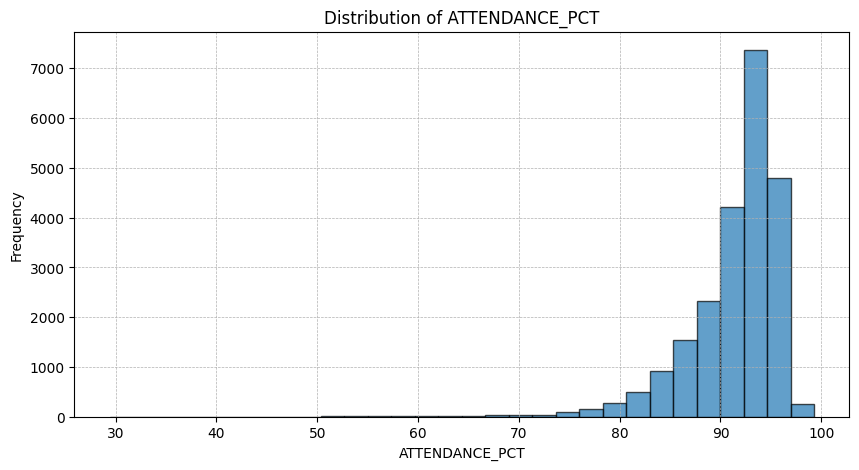

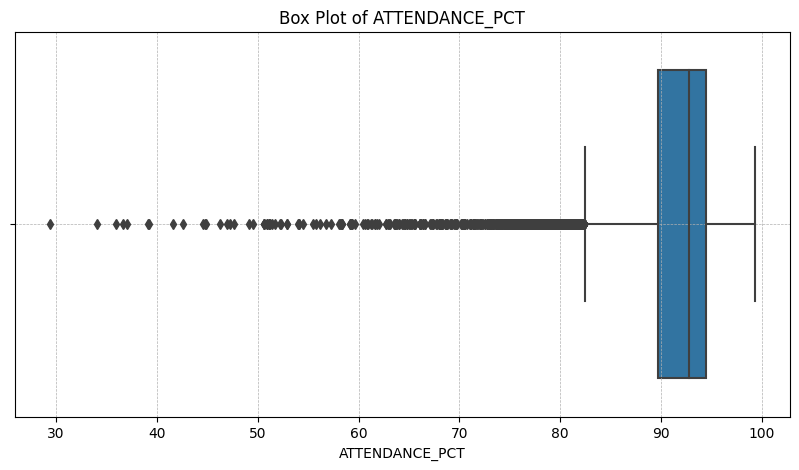

In [6]:
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=False)
attendance_data = con.execute("SELECT ATTENDANCE_PCT FROM STUDENT_ATTENDANCE_UNPIVOTED").fetchdf()
# Convert 'na' and other non-numeric entries to NaN for visualization
attendance_data['ATTENDANCE_PCT'] = pd.to_numeric(attendance_data['ATTENDANCE_PCT'], errors='coerce')
# Plot histogram for ATTENDANCE_PCT
plt.figure(figsize=(10, 5))
plt.hist(attendance_data['ATTENDANCE_PCT'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of ATTENDANCE_PCT')
plt.xlabel('ATTENDANCE_PCT')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Plotting box plot for ATTENDANCE_PCT
plt.figure(figsize=(10, 5))
sns.boxplot(x=attendance_data['ATTENDANCE_PCT'])
plt.title('Box Plot of ATTENDANCE_PCT')
plt.xlabel('ATTENDANCE_PCT')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

##### Given that the ATTENDANCE_PCT data is right-skewed, imputing with the mean could result in an overestimation, since the mean is influenced by the long right tail of the distribution. In such cases, the median, which is the middle value of the dataset and thus less sensitive to outliers and skewed data, is often a better choice. For categorical data or data with specific labels like 'sp', the mode (the most frequently occurring value) is typically used. If 'sp' has a specific meaning (e.g., special case, specific point) and is not just a placeholder for missing data, you shouldn't impute it in the same way as you would for 'na'. Instead, handle it based on its specific context.
##### To summarize:
##### For numeric columns like ATTENDANCE_PCT with 'na' values, use the median to impute the missing values.
##### For categorical columns or specific labels like 'sp', use mode or handle them based on their specific meaning.

In [9]:
import numpy as np

# Convert any 'NULL' values to numpy's NaN for compatibility with pandas
attendance_data.replace('NULL', np.nan, inplace=True)

# Impute the missing values with the median
median_value = attendance_data['ATTENDANCE_PCT'].median()
attendance_data['ATTENDANCE_PCT'].fillna(median_value, inplace=True)

# Check if there are still any missing values left
missing_values = attendance_data['ATTENDANCE_PCT'].isnull().sum()

print(f"There are {missing_values} missing values in the ATTENDANCE_PCT column.")


There are 0 missing values in the ATTENDANCE_PCT column.


In [ ]:
# Iterate through the DataFrame and update NULL values in the database
for index, row in attendance_data.iterrows():
    if pd.isnull(row['ATTENDANCE_PCT']):
        con.execute(f"UPDATE STUDENT_ATTENDANCE_UNPIVOTED SET ATTENDANCE_PCT = {median_value} WHERE School_Code = {row['School_Code']} AND Year = {row['Year']}")

# Commit the changes and close the connection
con.commit()
con.close()
